In [1]:
# 1. 표준 라이브러리
import sys
from pathlib import Path
import platform
import time
import json
import os
import joblib
from datetime import datetime
from typing import Optional
from dataclasses import dataclass


# 2. 서드파티 라이브러리 

# 2-1. 시각화
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

# 2-2. 
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score, 
    precision_score, f1_score, fbeta_score, average_precision_score, balanced_accuracy_score, precision_recall_fscore_support
)
from scipy.stats import uniform, randint
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.base import BaseEstimator

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR, MODEL_DIR

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

milk: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
milk.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),무지고형분,MUN,305일유량,305일무지고형분,전산차비유지속성,전산차건유전유량,...,농후사료급여량(연계),공태일수,비유단계,계절,농장구분,정액코드분류,가격,가격미달,분만간격,분만월령
0,20249,20120709020022,2020-01-11,154,0,1,9714.0,805.0,50.5,16.1,...,0.0,NaN,1,4,1,NaN,1056.34,0,NaN,85
1,20249,20120504020095,2020-01-11,52,0,1,NaN,NaN,68.8,22.6,...,0.0,NaN,1,4,1,NaN,1056.34,0,NaN,90
2,20249,20111008020210,2020-01-11,115,0,1,11008.0,971.0,54.1,24.5,...,0.0,NaN,2,4,1,NaN,1060.34,0,NaN,95
3,20249,20121014020049,2020-01-11,290,1,1,11318.0,1011.0,58.6,37.8,...,0.0,224.0,3,4,1,7HO,1062.31,0,NaN,77
4,20249,20130812020216,2020-01-11,100,0,1,11324.0,957.0,68.1,20.5,...,0.0,NaN,2,4,1,NaN,1056.34,0,NaN,75


In [4]:
df = milk

In [5]:
features = [
    '전산차건유전유량', 
    '산차', 
    '농후사료급여량(연계)', 
    '공태일수', 
    '계절', 
    '농장구분', 
    '분만간격',
    # '정액코드분류'
]

target = '가격미달'

## 범주형 처리

In [6]:
# categorical_features = ['정액코드분류']

# for categorical_feature in categorical_features:
#     df[categorical_feature] = df[categorical_feature].astype('category')

## Train Test Split

In [ ]:
split_date = '2021-08-01'
train = df[df['검정일자'] < split_date]
test = df[df['검정일자'] >= split_date]

X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

In [8]:
train.shape, test.shape

((31743, 22), (8521, 22))

In [9]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# ============================================
# 1. 클래스 비율 확인
# ============================================
print("="*60)
print("클래스 분포 분석")
print("="*60)
print(y_train.value_counts().sort_index())
print(f"\n비율:")
print(y_train.value_counts(normalize=True).sort_index())

# ✅ 수정: 0이 일반가(다수), 1이 가격미달(소수)
majority_count = (y_train == 0).sum()   # 일반가 (다수) - 약 90%
minority_count = (y_train == 1).sum()   # 가격미달 (소수) - 약 10%

print(f"\n클래스 구성:")
print(f"   0 (일반가, 다수): {majority_count}개 ({majority_count/len(y_train)*100:.1f}%)")
print(f"   1 (가격미달, 소수): {minority_count}개 ({minority_count/len(y_train)*100:.1f}%)")

# ✅ scale_pos_weight: 양성 클래스(1=가격미달=소수)에 대한 가중치
# 공식: (다수 클래스 개수) / (소수 클래스 개수)
scale_pos_weight = majority_count / minority_count

print(f"\n계산된 scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   → LightGBM은 자동으로 클래스 1(가격미달)에 이 가중치 적용")

# 결측치 확인
print("\n결측치 현황:")
missing_info = pd.DataFrame({
    'Feature': X_train.columns,
    '결측_개수': X_train.isnull().sum().values,
    '결측_비율(%)': (X_train.isnull().mean() * 100).values
}).sort_values('결측_비율(%)', ascending=False)
print(missing_info.head(10))
print(f"\n전체 결측 비율: {X_train.isnull().mean().mean()*100:.1f}%")
print(f"Feature 개수: {X_train.shape[1]}개")


클래스 분포 분석
가격미달
0    28406
1     3337
Name: count, dtype: int64

비율:
가격미달
0    0.894874
1    0.105126
Name: proportion, dtype: float64

클래스 구성:
   0 (일반가, 다수): 28406개 (89.5%)
   1 (가격미달, 소수): 3337개 (10.5%)

계산된 scale_pos_weight: 8.51
   → LightGBM은 자동으로 클래스 1(가격미달)에 이 가중치 적용

결측치 현황:
       Feature  결측_개수   결측_비율(%)
6         분만간격  20733  65.315188
3         공태일수  13326  41.980909
0     전산차건유전유량  12489  39.344107
2  농후사료급여량(연계)      0   0.000000
1           산차      0   0.000000
4           계절      0   0.000000
5         농장구분      0   0.000000

전체 결측 비율: 20.9%
Feature 개수: 7개


In [ ]:

# ============================================
# 2. Pipeline 구성
# ============================================

pipeline = ImbPipeline([
    ('model', LGBMClassifier(
        objective='binary',
        device='gpu',
        random_state=42,
        verbosity=-1,
        n_jobs=5,
        boost_from_average=False,
        # scale_pos_weight=scale_pos_weight,  # ✅ 자동으로 pos_label=1에 적용
        # bagging_freq=1,
        # pos_bagging_fraction=1,
        # neg_bagging_fraction=0.25,
        force_col_wise=True,
        metric='None',  # 🔥 추가: 기본 메트릭 끄기
    ))
])

print("\n✅ Pipeline 구성:")
print("   1. LGBMClassifier (GPU)")
print(f"      - scale_pos_weight={scale_pos_weight:.2f} (클래스 1=가격미달 가중치)")

# ============================================
# 3. 파라미터 분포
# ============================================
print(f"\n소수 클래스(1=가격미달) 샘플 수: {minority_count}개")

param_distributions = {
    # 🔥 LightGBM 파라미터 - 소수 클래스 민감도 향상
    'model__n_estimators': randint(600, 1000),
    'model__learning_rate': uniform(0.005, 0.045),
    'model__max_depth': randint(3, 8),
    'model__num_leaves': randint(15, 80),
    'model__min_child_samples': randint(5, 50),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': [1e-5, 1e-4, 1e-3, 1e-2],
    'model__reg_alpha': uniform(0, 0.5),
    'model__reg_lambda': uniform(0, 0.5),
    
    # 불균형 처리
    'model__scale_pos_weight': uniform(5.0, 4.0),
    
    # 범주형 처리
    # 'model__cat_l2': uniform(5.0, 15.0), 
}


# ============================================
# 4. Scoring 설정
# ============================================

scoring = {
    'recall': make_scorer(recall_score),
    'f2': make_scorer(fbeta_score, beta=2),              
    'pr_auc': make_scorer(average_precision_score, response_method='predict_proba'),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0, average='macro'),
    'roc_auc': 'roc_auc'                                           
}

main_score = 'precision'

print("\n✅ Scoring 전략:")
print(f"   메인 목표: {main_score.upper()}")
print(f"   타깃: 클래스 1 (가격미달) 검출 최적화")
print(f"   pos_label: 1 (기본값, 생략 가능)")

# ============================================
# 5. Stratified K-Fold
# ============================================
n_folds = 5
n_iter = 300
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


print(f"\n교차검증 Folds: {n_folds}")
print(f"랜덤 샘플링 조합 수: {n_iter}개")
print(f"총 Fits: {n_iter} × {n_folds} = {n_iter * n_folds}")

# ============================================
# 6. RandomizedSearchCV 실행
# ============================================

print("\n" + "="*60)
print("🚀 RandomizedSearchCV 시작!")
print("="*60)

lgbm_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    refit=main_score,
    verbose=3,
    random_state=42,
    n_jobs=5,
    error_score=np.nan 
)

start_actual = time.time()
lgbm_random.fit(X_train, y_train)
actual_time = time.time() - start_actual

# ============================================
# 7. 결과 출력
# ============================================
print("\n" + "="*60)
print("✅ 완료!")
print("="*60)
print(f"⏱️  소요 시간: {actual_time/60:.1f}분 ({actual_time:.0f}초)")

print(f"\n🏆 최고 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")

print("\n📋 최적 파라미터:")
for key, value in sorted(lgbm_random.best_params_.items()):
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")



✅ Pipeline 구성:
   1. LGBMClassifier (GPU)
      - scale_pos_weight=8.51 (클래스 1=가격미달 가중치)

소수 클래스(1=가격미달) 샘플 수: 3337개

✅ Scoring 전략:
   메인 목표: PRECISION
   타깃: 클래스 1 (가격미달) 검출 최적화
   pos_label: 1 (기본값, 생략 가능)

교차검증 Folds: 5
랜덤 샘플링 조합 수: 300개
총 Fits: 300 × 5 = 1500

🚀 RandomizedSearchCV 시작!
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 3/5] END model__colsample_bytree=0.749816047538945, model__learning_rate=0.047782143788446224, model__max_depth=5, model__min_child_samples=12, model__min_child_weight=1e-05, model__n_estimators=620, model__num_leaves=38, model__reg_alpha=0.32544423647442644, model__reg_lambda=0.028205789513550128, model__scale_pos_weight=11.497988950401423, model__subsample=0.9754210836063001; f1: (test=0.574) f2: (test=0.464) pr_auc: (test=0.341) precision: (test=0.218) recall: (test=0.645) roc_auc: (test=0.741) total time=   7.6s
[CV 4/5] END model__colsample_bytree=0.749816047538945, model__learning_rate=0.047782143788446224, model__max_depth=5, 

In [11]:

# ============================================
# 8. 전체 결과 비교
# ============================================
results_df = pd.DataFrame(lgbm_random.cv_results_)

scoring_cols = [f'mean_test_{score}' for score in scoring.keys()]

comparison_cols = [f'rank_test_{main_score}'] + scoring_cols + ['params']

print("\n" + "="*60)
print(f"📊 상위 10개 파라미터 조합 ({main_score.upper()} 기준)")
print("="*60)
top_10 = results_df[comparison_cols].sort_values(f'rank_test_{main_score}').head(10)

for idx, row in top_10.iterrows():
    rank = int(row[f'rank_test_{main_score}'])
    pr_auc = row[f'mean_test_pr_auc']
    recall = row['mean_test_recall']
    f2 = row['mean_test_f2']
    precision = row['mean_test_precision']
    f1 = row['mean_test_f1']
    
    print(f"\n#{rank} - {main_score.upper()}: {row[f'mean_test_{main_score}']:.4f} | Recall: {recall:.4f}")
    print(f"   F2: {f2:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")
    
    params = row['params']
    print(f"   Model: lr={params.get('model__learning_rate', 0):.4f}, "
          f"depth={params.get('model__max_depth', 0)}, "
          f"leaves={params.get('model__num_leaves', 0)}")

# ============================================
# 9. 테스트 세트 평가
# ============================================
print("\n" + "="*60)
print("🧪 테스트 세트 평가")
print("="*60)

best_model = lgbm_random.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# ✅ 클래스 1(가격미달)의 확률 추출
y_pred_proba_minority = y_pred_proba[:, 1]  # ✅ 인덱스 1 = 클래스 1 = 가격미달

print(classification_report(
    y_test, y_pred, 
    target_names=['0 (일반가, 다수)', '1 (가격미달, 소수)']
))

print("\n혼동 행렬:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['실제_0 (일반가)', '실제_1 (가격미달)'],
                     columns=['예측_0 (일반가)', '예측_1 (가격미달)'])
print(cm_df)

# ✅ 혼동 행렬 해석 수정
# confusion_matrix 구조:
#              예측_0  예측_1
# 실제_0 (일반가)  TN      FP
# 실제_1 (가격미달)   FN      TP

tn, fp, fn, tp = cm.ravel()

print("\n💼 비즈니스 해석 (소수 클래스=1=가격미달 기준):")
print(f"   ✅ 정확한 분류: {tn + tp}개 ({(tn+tp)/len(y_test)*100:.1f}%)")
print(f"   ⚠️  오탐 (FP): {fp}개 → 일반가을 가격미달로 오판 (재검사 필요)")
print(f"   🚨 미탐 (FN): {fn}개 → 가격미달를 일반가으로 오판 (치명적!)")

# ✅ Recall 계산: TP / (TP + FN)
if tp + fn > 0:
    recall_pct = tp/(tp+fn)*100
    print(f"\n   📊 소수 클래스(1=가격미달) Recall: {recall_pct:.1f}%")
    print(f"      → 가격미달 {tp+fn}개 중 {tp}개 검출 ({fn}개 놓침)")
else:
    print(f"\n   📊 소수 클래스(1=가격미달) Recall: N/A")

# ✅ Precision 계산: TP / (TP + FP)
if tp + fp > 0:
    precision_pct = tp/(tp+fp)*100
    print(f"   📊 소수 클래스(1=가격미달) Precision: {precision_pct:.1f}%")
    print(f"      → 가격미달 판정 {tp+fp}개 중 {tp}개 정답")
else:
    print(f"   📊 소수 클래스(1=가격미달) Precision: N/A")

test_roc_auc = roc_auc_score(y_test, y_pred_proba_minority)
print(f"   📊 ROC-AUC: {test_roc_auc:.4f}")

# ============================================
# 10. 🔥 임계값 조정으로 추가 개선
# ============================================
from sklearn.metrics import precision_recall_curve, average_precision_score

# ✅ pos_label=1 (가격미달) 기준으로 PR 곡선 계산
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_pred_proba_minority
)

# Recall 50% 보장
target_recall = 0.5
idx = np.where(recalls >= target_recall)[0]

if len(idx) > 0:
    best_idx = idx[np.argmax(precisions[idx])]
    optimal_threshold = thresholds[best_idx]
    
    print("\n" + "="*60)
    print(f"🎯 Recall {target_recall*100}% 보장 시 최적 임계값")
    print("="*60)
    print(f"최적 임계값: {optimal_threshold:.3f} (기본값 0.5)")
    print(f"Precision: {precisions[best_idx]:.3f}")
    print(f"Recall: {recalls[best_idx]:.3f}")
    
    # ✅ 임계값 조정: 확률 >= threshold이면 클래스 1(가격미달)로 예측
    y_pred_adjusted = (y_pred_proba_minority >= optimal_threshold).astype(int)
    
    cm_adj = confusion_matrix(y_test, y_pred_adjusted)
    tn2, fp2, fn2, tp2 = cm_adj.ravel()
    
    print(f"\n조정 효과:")
    print(f"   미탐(FN) 감소: {fn} → {fn2} (개선: {fn-fn2}개)")
    print(f"   오탐(FP) 증가: {fp} → {fp2} (증가: {fp2-fp}개)")
    
    if tp + fn > 0 and tp2 + fn2 > 0:
        print(f"   Recall 개선: {tp/(tp+fn)*100:.1f}% → {tp2/(tp2+fn2)*100:.1f}%")
    
    if fn > fn2:
        print(f"   💡 가격미달를 일반가으로 오판하는 치명적 오류 {fn-fn2}개 감소!")
else:
    print(f"\n⚠️  Recall {target_recall*100}% 달성 불가 (최대 Recall: {recalls.max():.2%})")

# ============================================
# 11. 변수 중요도 확인
# ============================================
print("\n" + "="*60)
print("📊 변수 중요도 Top 10")
print("="*60)

final_model = best_model.named_steps['model']
feature_names = list(X_train.columns)

n_features_used = len(final_model.feature_importances_)
feature_names = feature_names[:n_features_used]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))

# ============================================
# 12. 교차검증 vs 테스트 성능 비교
# ============================================
print("\n" + "="*60)
print("📈 성능 비교: 교차검증 vs 테스트")
print("="*60)

# ✅ pos_label=1 기본값 사용
test_metrics = {
    'PR-AUC': average_precision_score(y_test, y_pred_proba_minority),
    'Recall': recall_score(y_test, y_pred),
    'F2': fbeta_score(y_test, y_pred, beta=2),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': test_roc_auc
}

print(f"{'지표':<15} {'교차검증 (CV)':<20} {'테스트':<15} {'차이':<10}")
print("-" * 60)

for metric in ['PR-AUC', 'Recall', 'F2', 'Precision', 'F1', 'ROC-AUC']:
    cv_key = metric.lower().replace('-', '_')
    cv_score = results_df.loc[results_df[f'rank_test_{main_score}'] == 1, f'mean_test_{cv_key}'].values[0]
    test_score = test_metrics[metric]
    diff = test_score - cv_score
    
    diff_str = f"{diff:+.4f}"
    if abs(diff) > 0.05:
        diff_str += " ⚠️"
    
    print(f"{metric:<15} {cv_score:<20.4f} {test_score:<15.4f} {diff_str}")

# ============================================
# 13. 최종 요약
# ============================================
print("\n" + "="*60)
print(f"📝 최종 요약 ({main_score.upper()} 최적화)")
print("="*60)
print(f"✅ 최적 모델 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")
print(f"✅ 테스트 Recall: {test_metrics['Recall']*100:.1f}% (가격미달 검출률)")
print(f"✅ 테스트 Precision: {test_metrics['Precision']*100:.1f}% (가격미달 판정 정확도)")
print(f"✅ 테스트 F1: {test_metrics['F1']:.4f}")
print(f"✅ 치명적 오류(미탐 FN): {fn}개 / {tp+fn}개")
print(f"⏱️  총 소요 시간: {actual_time/60:.1f}분")

print("\n💡 핵심 포인트:")
print(f"   - 가격미달(1) {tp+fn}개 중 {tp}개 검출 ({tp/(tp+fn)*100:.1f}%)")
print(f"   - 놓친 가격미달: {fn}개")
print(f"   - 오탐 (일반가→가격미달): {fp}개 (재검사 필요)")

# ============================================
# 14. 모델 + 파라미터 저장
# ============================================
print("\n" + "="*60)
print("💾 모델 및 파라미터 저장")
print("="*60)

save_model_input = input("모델을 저장하시겠습니까? (y/n): ")
if save_model_input.lower() == 'y':
    
    # MODEL_DIR이 정의되지 않은 경우 현재 디렉토리 사용
    try:
        MODEL_DIR = Path(MODEL_DIR)
    except:
        MODEL_DIR = Path('.')
        print(f"⚠️  MODEL_DIR 미정의, 현재 디렉토리 사용: {MODEL_DIR.absolute()}")
    
    MODEL_DIR.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_filename = MODEL_DIR / f'best_lgbm_{main_score}_optimized_{timestamp}.pkl'
    params_filename = MODEL_DIR / f'best_params_{main_score}_{timestamp}.json'
    metrics_filename = MODEL_DIR / f'test_metrics_{main_score}_{timestamp}.json'
    results_filename = MODEL_DIR / f'cv_results_{main_score}_{timestamp}.csv'
    
    # 1. 모델 저장
    joblib.dump(best_model, model_filename)
    print(f"✅ 모델 저장: {model_filename}")
    
    # 2. 파라미터 저장
    best_params_serializable = {}
    for key, value in lgbm_random.best_params_.items():
        if isinstance(value, (np.integer, np.floating)):
            best_params_serializable[key] = float(value) if isinstance(value, np.floating) else int(value)
        else:
            best_params_serializable[key] = value
    
    params_info = {
        'best_params': best_params_serializable,
        f'best_{main_score}_score': float(lgbm_random.best_score_),
        'optimization_target': main_score,
        'cv_folds': n_folds,
        'n_iter': n_iter,
        'timestamp': timestamp,
        'class_labels': {
            '0': '일반가 (다수)',
            '1': '가격미달 (소수)'
        },
        'minority_count': int(minority_count),
        'majority_count': int(majority_count),
        'scale_pos_weight': float(scale_pos_weight),
        'features': features,
        'train_test_split': split_date
    }
    
    with open(params_filename, 'w', encoding='utf-8') as f:
        json.dump(params_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 파라미터 저장: {params_filename}")
    
    # 3. 테스트 성능 저장
    test_metrics_serializable = {
        key: float(value) if isinstance(value, (np.floating, np.integer)) else value
        for key, value in test_metrics.items()
    }
    
    metrics_info = {
        'test_metrics': test_metrics_serializable,
        'confusion_matrix': {
            'tn': int(tn),  # 일반가 → 일반가 (정답)
            'fp': int(fp),  # 일반가 → 가격미달 (오탐)
            'fn': int(fn),  # 가격미달 → 일반가 (미탐, 치명적!)
            'tp': int(tp)   # 가격미달 → 가격미달 (정답)
        },
        'business_interpretation': {
            'total_minority': int(tp + fn),      # 실제 가격미달 개수
            'detected_minority': int(tp),        # 검출된 가격미달
            'missed_minority': int(fn),          # 놓친 가격미달 (치명적)
            'recall_percentage': float(tp/(tp+fn)*100) if (tp+fn) > 0 else 0,
            'false_alarms': int(fp)              # 일반가을 가격미달로 오판
        },
        'timestamp': timestamp
    }
    
    with open(metrics_filename, 'w', encoding='utf-8') as f:
        json.dump(metrics_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 테스트 성능 저장: {metrics_filename}")
    
    # 4. CV 결과 저장
    results_df.to_csv(results_filename, index=False, encoding='utf-8')
    print(f"✅ CV 결과 저장: {results_filename}")
    
    print("\n📦 저장된 파일 요약:")
    print(f"1. 모델: {model_filename.name}")
    print(f"2. 파라미터: {params_filename.name}")
    print(f"3. 성능: {metrics_filename.name}")
    print(f"4. CV결과: {results_filename.name}")
    
else:
    print("모델 저장 생략")

print("\n" + "="*60)
print("🎉 모든 작업 완료!")
print("="*60)


📊 상위 10개 파라미터 조합 (PRECISION 기준)

#1 - PRECISION: 0.3855 | Recall: 0.4660
   F2: 0.447 | Precision: 0.385 | F1: 0.673
   Model: lr=0.0442, depth=7, leaves=66

#2 - PRECISION: 0.3697 | Recall: 0.4714
   F2: 0.447 | Precision: 0.370 | F1: 0.667
   Model: lr=0.0421, depth=6, leaves=60

#3 - PRECISION: 0.3654 | Recall: 0.4636
   F2: 0.440 | Precision: 0.365 | F1: 0.664
   Model: lr=0.0351, depth=6, leaves=49

#4 - PRECISION: 0.3645 | Recall: 0.4705
   F2: 0.444 | Precision: 0.364 | F1: 0.665
   Model: lr=0.0489, depth=6, leaves=68

#5 - PRECISION: 0.3541 | Recall: 0.4843
   F2: 0.451 | Precision: 0.354 | F1: 0.662
   Model: lr=0.0280, depth=7, leaves=57

#6 - PRECISION: 0.3538 | Recall: 0.4300
   F2: 0.412 | Precision: 0.354 | F1: 0.654
   Model: lr=0.0177, depth=6, leaves=50

#7 - PRECISION: 0.3509 | Recall: 0.4729
   F2: 0.442 | Precision: 0.351 | F1: 0.659
   Model: lr=0.0393, depth=6, leaves=72

#8 - PRECISION: 0.3497 | Recall: 0.4231
   F2: 0.406 | Precision: 0.350 | F1: 0.651
   Mode

In [ ]:
models = [
    'best_lgbm_pr_auc_optimized_20251108_221353'
    'best_lgbm_pr_auc_optimized_20251106_215224',
    'best_lgbm_pr_auc_optimized_20251108_223541',
    'best_lgbm_pr_auc_optimized_20251108_225820',
    'best_lgbm_precision_optimized_20251108_232046',
    'best_lgbm_f1_optimized_20251108_235801',
    'best_lgbm_pr_auc_optimized_20251109_001812',
    'best_lgbm_pr_auc_optimized_20251109_004121',
    'best_lgbm_precision_optimized_20251109_012906',
    'best_lgbm_precision_optimized_20251109_021948', 
    'best_lgbm_precision_optimized_20251109_023236',
    'best_lgbm_precision_optimized_20251109_041233',
    'best_lgbm_precision_optimized_20251109_090643'
]

In [111]:
import joblib
loaded_model = joblib.load(MODEL_DIR / 'best_lgbm_precision_optimized_20251109_041233.pkl')

In [103]:
# 테스트셋 성능 평가
y_pred = loaded_model.predict(X_test)
y_prob = loaded_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"ROC-AUC (Test Set): {roc_auc:.3f}")
print(f"PR-AUC (Test Set): {pr_auc:.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.917     0.920     0.918      7550
           1      0.358     0.349     0.354       971

    accuracy                          0.855      8521
   macro avg      0.637     0.634     0.636      8521
weighted avg      0.853     0.855     0.854      8521


Balanced Accuracy (Test Set): 0.634
ROC-AUC (Test Set): 0.688
PR-AUC (Test Set): 0.3083


In [ ]:
thr_list = np.round(np.arange(0.1, 1.0, 0.01), 2)
rows = []
for thr in thr_list:
    y_hat = (y_prob >= thr).astype(int)
    rows.append([
        thr,
        precision_score(y_test, y_hat, zero_division=0),
        recall_score(y_test, y_hat, zero_division=0),
        f1_score(y_test, y_hat, zero_division=0)
    ])

thr_table = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall', 'f1'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["precision"],
                         mode="lines", name="Precision",
                         line=dict(dash="dash", color="cyan")))
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["recall"],
                         mode="lines", name="Recall",
                         line=dict(color="magenta")))
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["f1"],
                         mode="lines", name="F1",
                         line=dict(color="yellow")))

fig.update_layout(title="임곗값 변화에 따른 Precision/Recall/F1",
                  xaxis_title="Threshold",
                  yaxis_title="Score",
                  yaxis=dict(range=[0,1]),
                  template="plotly_dark")
fig.show()

In [106]:
import joblib
loaded_model = joblib.load(MODEL_DIR / 'best_lgbm_precision_optimized_20251109_041233.pkl')

params = loaded_model.named_steps['model'].get_params()

params['n_estimators'] = 1000000
params['learning_rate'] = 0.005
# params['num_leaves'] = 10
# params['max_depth'] = 5
# params['verbosity'] = 1
# params['metric'] = 'precision'

X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

display(params)

# pipeline = ImbPipeline([
#     ('model', LGBMClassifier(**params))
# ])

lgbm_model = LGBMClassifier(
    **params
)


def custom_precision(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    return 'precision', precision_score(y_true, y_pred), True

lgbm_model.fit(
    X_train2, y_train2,
    eval_set=[(X_valid, y_valid)],  # train, valid 둘 다
    eval_names=['valid'],  # 이름 지정
    eval_metric=[custom_precision, 'average_precision'],  # PR-AUC (불균형 데이터에 적합)
    callbacks=[
        early_stopping(stopping_rounds=5000, verbose=True),
        log_evaluation(period=100)  # 100 iteration마다 출력
    ]
)


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': np.float64(0.6182968135250051),
 'importance_type': 'split',
 'learning_rate': 0.005,
 'max_depth': 7,
 'min_child_samples': 16,
 'min_child_weight': 0.01,
 'min_split_gain': 0.0,
 'n_estimators': 1000000,
 'n_jobs': 5,
 'num_leaves': 66,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': np.float64(0.3791315979645113),
 'reg_lambda': np.float64(0.012293458229400755),
 'subsample': np.float64(0.7294440876598165),
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'gpu',
 'verbosity': -1,
 'boost_from_average': False,
 'force_col_wise': True,
 'metric': 'None',
 'scale_pos_weight': np.float64(5.199111963760975)}

Training until validation scores don't improve for 5000 rounds
[100]	valid's average_precision: 0.282472	valid's precision: 0.312704
[200]	valid's average_precision: 0.283929	valid's precision: 0.294872
[300]	valid's average_precision: 0.286439	valid's precision: 0.298103
[400]	valid's average_precision: 0.295412	valid's precision: 0.29572
[500]	valid's average_precision: 0.303666	valid's precision: 0.293436
[600]	valid's average_precision: 0.308874	valid's precision: 0.307497
[700]	valid's average_precision: 0.311904	valid's precision: 0.321337
[800]	valid's average_precision: 0.316452	valid's precision: 0.320413
[900]	valid's average_precision: 0.320232	valid's precision: 0.32732
[1000]	valid's average_precision: 0.323022	valid's precision: 0.333333
[1100]	valid's average_precision: 0.323566	valid's precision: 0.336329
[1200]	valid's average_precision: 0.324248	valid's precision: 0.3342
[1300]	valid's average_precision: 0.325311	valid's precision: 0.332481
[1400]	valid's average_prec

,boosting_type,'gbdt'
,num_leaves,66
,max_depth,7
,learning_rate,0.005
,n_estimators,1000000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.01
,min_child_samples,16


In [107]:


# 테스트셋 성능 평가
y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.512).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"ROC-AUC (Test Set): {roc_auc:.3f}")
print(f"PR-AUC (Test Set): {pr_auc:.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.912     0.931     0.921      7550
           1      0.357     0.300     0.326       971

    accuracy                          0.859      8521
   macro avg      0.635     0.615     0.624      8521
weighted avg      0.849     0.859     0.853      8521


Balanced Accuracy (Test Set): 0.615
ROC-AUC (Test Set): 0.655
PR-AUC (Test Set): 0.2791


In [95]:
thr_list = np.round(np.arange(0.1, 1.0, 0.01), 2)
rows = []
for thr in thr_list:
    y_hat = (y_prob >= thr).astype(int)
    rows.append([
        thr,
        precision_score(y_test, y_hat, zero_division=0),
        recall_score(y_test, y_hat, zero_division=0),
        f1_score(y_test, y_hat, zero_division=0)
    ])

thr_table = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall', 'f1'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["precision"],
                         mode="lines", name="Precision",
                         line=dict(dash="dash", color="cyan")))
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["recall"],
                         mode="lines", name="Recall",
                         line=dict(color="magenta")))
fig.add_trace(go.Scatter(x=thr_table["threshold"], y=thr_table["f1"],
                         mode="lines", name="F1",
                         line=dict(color="yellow")))

fig.update_layout(title="임곗값 변화에 따른 Precision/Recall/F1",
                  xaxis_title="Threshold",
                  yaxis_title="Score",
                  yaxis=dict(range=[0,1]),
                  template="plotly_dark")
fig.show()

In [108]:
model = loaded_model.named_steps['model']

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



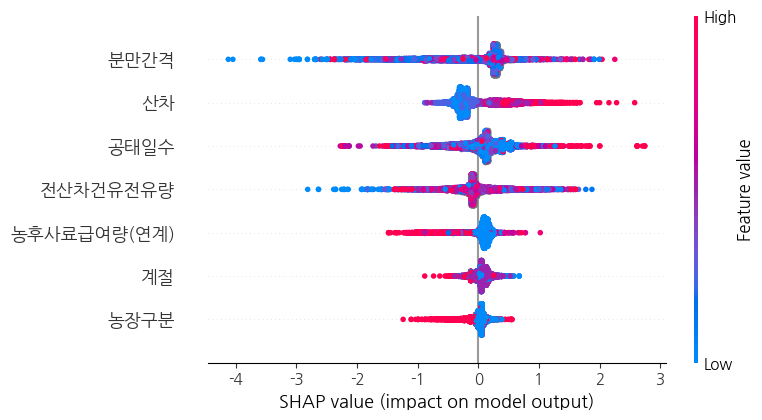

In [112]:
import shap

# SHAP 적용
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test)


In [ ]:
# mean absolute shap value per feature
shap_importance = np.abs(shap_values).mean(axis=0)
print(shap_importance)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance', ascending=False)

print(shap_df)

[0.30664478 0.34082085 0.18488836 0.31309283 0.10784332 0.10105119
 0.50106841]
       feature  shap_importance
6         분만간격         0.501068
1           산차         0.340821
3         공태일수         0.313093
0     전산차건유전유량         0.306645
2  농후사료급여량(연계)         0.184888
4           계절         0.107843
5         농장구분         0.101051


## 집중학습

In [38]:
# ============================================
# 2. Pipeline 구성
# ============================================

pipeline = ImbPipeline([
    ('model', LGBMClassifier(
        objective='binary',
        device='gpu',
        random_state=42,
        verbosity=-1,
        n_jobs=5,
        boost_from_average=False,
        # scale_pos_weight=scale_pos_weight,  # ✅ 자동으로 pos_label=1에 적용
        # bagging_freq=1,
        # pos_bagging_fraction=1,
        # neg_bagging_fraction=0.25,
        force_col_wise=True,
        metric='None',  # 🔥 추가: 기본 메트릭 끄기
    ))
])

print("\n✅ Pipeline 구성:")
print("   1. LGBMClassifier (GPU)")
print(f"      - scale_pos_weight={scale_pos_weight:.2f} (클래스 1=가격미달 가중치)")

# ============================================
# 3. 파라미터 분포
# ============================================
print(f"\n소수 클래스(1=가격미달) 샘플 수: {minority_count}개")

best_params = {
    "model__colsample_bytree": 0.6182968135250051,
    "model__learning_rate": 0.04421915627685693,
    "model__max_depth": 7,
    "model__min_child_samples": 16,
    "model__min_child_weight": 0.01,
    "model__n_estimators": 850,
    "model__num_leaves": 66,
    "model__reg_alpha": 0.3791315979645113,
    "model__reg_lambda": 0.012293458229400755,
    "model__scale_pos_weight": 5.199111963760975,
    "model__subsample": 0.7294440876598165
}

param_distributions = {
    # 🔥 LightGBM 파라미터 - 소수 클래스 민감도 향상
    'model__n_estimators': randint(800, 2000),
    'model__learning_rate': uniform(0.04, 0.05),
    'model__max_depth': randint(3, 6),
    'model__num_leaves': randint(15, 50),
    'model__min_child_samples': randint(20, 50),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.6, 0.2),
    'model__min_child_weight': [0.01],
    'model__reg_alpha': uniform(0.3, 0.5),
    'model__reg_lambda': uniform(0, 0.1),
    
    # 불균형 처리
    'model__scale_pos_weight': uniform(5.0, 6.0),
    
    # 범주형 처리
    # 'model__cat_l2': uniform(5.0, 15.0), 
}


# ============================================
# 4. Scoring 설정
# ============================================

scoring = {
    'recall': make_scorer(recall_score),
    'f2': make_scorer(fbeta_score, beta=2),              
    'pr_auc': make_scorer(average_precision_score, response_method='predict_proba'),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0, average='macro'),
    'roc_auc': 'roc_auc'                                           
}

main_score = 'precision'

print("\n✅ Scoring 전략:")
print(f"   메인 목표: {main_score.upper()}")
print(f"   타깃: 클래스 1 (가격미달) 검출 최적화")
print(f"   pos_label: 1 (기본값, 생략 가능)")

# ============================================
# 5. Stratified K-Fold
# ============================================
n_folds = 5
n_iter = 300
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


print(f"\n교차검증 Folds: {n_folds}")
print(f"랜덤 샘플링 조합 수: {n_iter}개")
print(f"총 Fits: {n_iter} × {n_folds} = {n_iter * n_folds}")

# ============================================
# 6. RandomizedSearchCV 실행
# ============================================

print("\n" + "="*60)
print("🚀 RandomizedSearchCV 시작!")
print("="*60)

lgbm_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    refit=main_score,
    verbose=3,
    random_state=42,
    n_jobs=5,
    error_score=np.nan 
)

start_actual = time.time()
lgbm_random.fit(X_train, y_train)
actual_time = time.time() - start_actual

# ============================================
# 7. 결과 출력
# ============================================
print("\n" + "="*60)
print("✅ 완료!")
print("="*60)
print(f"⏱️  소요 시간: {actual_time/60:.1f}분 ({actual_time:.0f}초)")

print(f"\n🏆 최고 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")

print("\n📋 최적 파라미터:")
for key, value in sorted(lgbm_random.best_params_.items()):
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")



✅ Pipeline 구성:
   1. LGBMClassifier (GPU)
      - scale_pos_weight=8.51 (클래스 1=가격미달 가중치)

소수 클래스(1=가격미달) 샘플 수: 3337개

✅ Scoring 전략:
   메인 목표: PRECISION
   타깃: 클래스 1 (가격미달) 검출 최적화
   pos_label: 1 (기본값, 생략 가능)

교차검증 Folds: 5
랜덤 샘플링 조합 수: 300개
총 Fits: 300 × 5 = 1500

🚀 RandomizedSearchCV 시작!
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2

[CV 2/5] END model__colsample_bytree=0.6749080237694725, model__learning_rate=0.08753571532049581, model__max_depth=5, model__min_child_samples=27, model__min_child_weight=0.01, model__n_estimators=1844, model__num_leaves=33, model__reg_alpha=0.34998745790900143, model__reg_lambda=0.045924889196586716, model__scale_pos_weight=7.002251666834131, model__subsample=0.7428600453765822; f1: (test=0.658) f2: (test=0.460) pr_auc: (test=0.384) precision: (test=0.339) recall: (test=0.506) roc_auc: (test=0.753) total time=  19.0s
[CV 1/5] END model__colsample_bytree=0.6749080237694725, model__learning_rate=0.08753571532049581, model__max_depth=5, model__min_child_samples=27, model__min_child_weight=0.01, model__n_estimators=1844, model__num_leaves=33, model__reg_alpha=0.34998745790900143, model__reg_lambda=0.045924889196586716, model__scale_pos_weight=7.002251666834131, model__subsample=0.7428600453765822; f1: (test=0.661) f2: (test=0.470) pr_auc: (test=0.383) precision: (test=0.340) recall: (tes

In [39]:

# ============================================
# 8. 전체 결과 비교
# ============================================
results_df = pd.DataFrame(lgbm_random.cv_results_)

scoring_cols = [f'mean_test_{score}' for score in scoring.keys()]

comparison_cols = [f'rank_test_{main_score}'] + scoring_cols + ['params']

print("\n" + "="*60)
print(f"📊 상위 10개 파라미터 조합 ({main_score.upper()} 기준)")
print("="*60)
top_10 = results_df[comparison_cols].sort_values(f'rank_test_{main_score}').head(10)

for idx, row in top_10.iterrows():
    rank = int(row[f'rank_test_{main_score}'])
    pr_auc = row[f'mean_test_pr_auc']
    recall = row['mean_test_recall']
    f2 = row['mean_test_f2']
    precision = row['mean_test_precision']
    f1 = row['mean_test_f1']
    
    print(f"\n#{rank} - {main_score.upper()}: {row[f'mean_test_{main_score}']:.4f} | Recall: {recall:.4f}")
    print(f"   F2: {f2:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")
    
    params = row['params']
    print(f"   Model: lr={params.get('model__learning_rate', 0):.4f}, "
          f"depth={params.get('model__max_depth', 0)}, "
          f"leaves={params.get('model__num_leaves', 0)}")

# ============================================
# 9. 테스트 세트 평가
# ============================================
print("\n" + "="*60)
print("🧪 테스트 세트 평가")
print("="*60)

best_model = lgbm_random.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# ✅ 클래스 1(가격미달)의 확률 추출
y_pred_proba_minority = y_pred_proba[:, 1]  # ✅ 인덱스 1 = 클래스 1 = 가격미달

print(classification_report(
    y_test, y_pred, 
    target_names=['0 (일반가, 다수)', '1 (가격미달, 소수)']
))

print("\n혼동 행렬:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['실제_0 (일반가)', '실제_1 (가격미달)'],
                     columns=['예측_0 (일반가)', '예측_1 (가격미달)'])
print(cm_df)

# ✅ 혼동 행렬 해석 수정
# confusion_matrix 구조:
#              예측_0  예측_1
# 실제_0 (일반가)  TN      FP
# 실제_1 (가격미달)   FN      TP

tn, fp, fn, tp = cm.ravel()

print("\n💼 비즈니스 해석 (소수 클래스=1=가격미달 기준):")
print(f"   ✅ 정확한 분류: {tn + tp}개 ({(tn+tp)/len(y_test)*100:.1f}%)")
print(f"   ⚠️  오탐 (FP): {fp}개 → 일반가을 가격미달로 오판 (재검사 필요)")
print(f"   🚨 미탐 (FN): {fn}개 → 가격미달를 일반가으로 오판 (치명적!)")

# ✅ Recall 계산: TP / (TP + FN)
if tp + fn > 0:
    recall_pct = tp/(tp+fn)*100
    print(f"\n   📊 소수 클래스(1=가격미달) Recall: {recall_pct:.1f}%")
    print(f"      → 가격미달 {tp+fn}개 중 {tp}개 검출 ({fn}개 놓침)")
else:
    print(f"\n   📊 소수 클래스(1=가격미달) Recall: N/A")

# ✅ Precision 계산: TP / (TP + FP)
if tp + fp > 0:
    precision_pct = tp/(tp+fp)*100
    print(f"   📊 소수 클래스(1=가격미달) Precision: {precision_pct:.1f}%")
    print(f"      → 가격미달 판정 {tp+fp}개 중 {tp}개 정답")
else:
    print(f"   📊 소수 클래스(1=가격미달) Precision: N/A")

test_roc_auc = roc_auc_score(y_test, y_pred_proba_minority)
print(f"   📊 ROC-AUC: {test_roc_auc:.4f}")

# ============================================
# 10. 🔥 임계값 조정으로 추가 개선
# ============================================
from sklearn.metrics import precision_recall_curve, average_precision_score

# ✅ pos_label=1 (가격미달) 기준으로 PR 곡선 계산
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_pred_proba_minority
)

# Recall 50% 보장
target_recall = 0.5
idx = np.where(recalls >= target_recall)[0]

if len(idx) > 0:
    best_idx = idx[np.argmax(precisions[idx])]
    optimal_threshold = thresholds[best_idx]
    
    print("\n" + "="*60)
    print(f"🎯 Recall {target_recall*100}% 보장 시 최적 임계값")
    print("="*60)
    print(f"최적 임계값: {optimal_threshold:.3f} (기본값 0.5)")
    print(f"Precision: {precisions[best_idx]:.3f}")
    print(f"Recall: {recalls[best_idx]:.3f}")
    
    # ✅ 임계값 조정: 확률 >= threshold이면 클래스 1(가격미달)로 예측
    y_pred_adjusted = (y_pred_proba_minority >= optimal_threshold).astype(int)
    
    cm_adj = confusion_matrix(y_test, y_pred_adjusted)
    tn2, fp2, fn2, tp2 = cm_adj.ravel()
    
    print(f"\n조정 효과:")
    print(f"   미탐(FN) 감소: {fn} → {fn2} (개선: {fn-fn2}개)")
    print(f"   오탐(FP) 증가: {fp} → {fp2} (증가: {fp2-fp}개)")
    
    if tp + fn > 0 and tp2 + fn2 > 0:
        print(f"   Recall 개선: {tp/(tp+fn)*100:.1f}% → {tp2/(tp2+fn2)*100:.1f}%")
    
    if fn > fn2:
        print(f"   💡 가격미달를 일반가으로 오판하는 치명적 오류 {fn-fn2}개 감소!")
else:
    print(f"\n⚠️  Recall {target_recall*100}% 달성 불가 (최대 Recall: {recalls.max():.2%})")

# ============================================
# 11. 변수 중요도 확인
# ============================================
print("\n" + "="*60)
print("📊 변수 중요도 Top 10")
print("="*60)

final_model = best_model.named_steps['model']
feature_names = list(X_train.columns)

n_features_used = len(final_model.feature_importances_)
feature_names = feature_names[:n_features_used]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))

# ============================================
# 12. 교차검증 vs 테스트 성능 비교
# ============================================
print("\n" + "="*60)
print("📈 성능 비교: 교차검증 vs 테스트")
print("="*60)

# ✅ pos_label=1 기본값 사용
test_metrics = {
    'PR-AUC': average_precision_score(y_test, y_pred_proba_minority),
    'Recall': recall_score(y_test, y_pred),
    'F2': fbeta_score(y_test, y_pred, beta=2),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': test_roc_auc
}

print(f"{'지표':<15} {'교차검증 (CV)':<20} {'테스트':<15} {'차이':<10}")
print("-" * 60)

for metric in ['PR-AUC', 'Recall', 'F2', 'Precision', 'F1', 'ROC-AUC']:
    cv_key = metric.lower().replace('-', '_')
    cv_score = results_df.loc[results_df[f'rank_test_{main_score}'] == 1, f'mean_test_{cv_key}'].values[0]
    test_score = test_metrics[metric]
    diff = test_score - cv_score
    
    diff_str = f"{diff:+.4f}"
    if abs(diff) > 0.05:
        diff_str += " ⚠️"
    
    print(f"{metric:<15} {cv_score:<20.4f} {test_score:<15.4f} {diff_str}")

# ============================================
# 13. 최종 요약
# ============================================
print("\n" + "="*60)
print(f"📝 최종 요약 ({main_score.upper()} 최적화)")
print("="*60)
print(f"✅ 최적 모델 {main_score.upper()} (CV): {lgbm_random.best_score_:.4f}")
print(f"✅ 테스트 Recall: {test_metrics['Recall']*100:.1f}% (가격미달 검출률)")
print(f"✅ 테스트 Precision: {test_metrics['Precision']*100:.1f}% (가격미달 판정 정확도)")
print(f"✅ 테스트 F1: {test_metrics['F1']:.4f}")
print(f"✅ 치명적 오류(미탐 FN): {fn}개 / {tp+fn}개")
print(f"⏱️  총 소요 시간: {actual_time/60:.1f}분")

print("\n💡 핵심 포인트:")
print(f"   - 가격미달(1) {tp+fn}개 중 {tp}개 검출 ({tp/(tp+fn)*100:.1f}%)")
print(f"   - 놓친 가격미달: {fn}개")
print(f"   - 오탐 (일반가→가격미달): {fp}개 (재검사 필요)")

# ============================================
# 14. 모델 + 파라미터 저장
# ============================================
print("\n" + "="*60)
print("💾 모델 및 파라미터 저장")
print("="*60)

save_model_input = input("모델을 저장하시겠습니까? (y/n): ")
if save_model_input.lower() == 'y':
    
    # MODEL_DIR이 정의되지 않은 경우 현재 디렉토리 사용
    try:
        MODEL_DIR = Path(MODEL_DIR)
    except:
        MODEL_DIR = Path('.')
        print(f"⚠️  MODEL_DIR 미정의, 현재 디렉토리 사용: {MODEL_DIR.absolute()}")
    
    MODEL_DIR.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_filename = MODEL_DIR / f'best_lgbm_{main_score}_optimized_{timestamp}.pkl'
    params_filename = MODEL_DIR / f'best_params_{main_score}_{timestamp}.json'
    metrics_filename = MODEL_DIR / f'test_metrics_{main_score}_{timestamp}.json'
    results_filename = MODEL_DIR / f'cv_results_{main_score}_{timestamp}.csv'
    
    # 1. 모델 저장
    joblib.dump(best_model, model_filename)
    print(f"✅ 모델 저장: {model_filename}")
    
    # 2. 파라미터 저장
    best_params_serializable = {}
    for key, value in lgbm_random.best_params_.items():
        if isinstance(value, (np.integer, np.floating)):
            best_params_serializable[key] = float(value) if isinstance(value, np.floating) else int(value)
        else:
            best_params_serializable[key] = value
    
    params_info = {
        'best_params': best_params_serializable,
        f'best_{main_score}_score': float(lgbm_random.best_score_),
        'optimization_target': main_score,
        'cv_folds': n_folds,
        'n_iter': n_iter,
        'timestamp': timestamp,
        'class_labels': {
            '0': '일반가 (다수)',
            '1': '가격미달 (소수)'
        },
        'minority_count': int(minority_count),
        'majority_count': int(majority_count),
        'scale_pos_weight': float(scale_pos_weight),
        'features': features,
        'train_test_split': split_date
    }
    
    with open(params_filename, 'w', encoding='utf-8') as f:
        json.dump(params_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 파라미터 저장: {params_filename}")
    
    # 3. 테스트 성능 저장
    test_metrics_serializable = {
        key: float(value) if isinstance(value, (np.floating, np.integer)) else value
        for key, value in test_metrics.items()
    }
    
    metrics_info = {
        'test_metrics': test_metrics_serializable,
        'confusion_matrix': {
            'tn': int(tn),  # 일반가 → 일반가 (정답)
            'fp': int(fp),  # 일반가 → 가격미달 (오탐)
            'fn': int(fn),  # 가격미달 → 일반가 (미탐, 치명적!)
            'tp': int(tp)   # 가격미달 → 가격미달 (정답)
        },
        'business_interpretation': {
            'total_minority': int(tp + fn),      # 실제 가격미달 개수
            'detected_minority': int(tp),        # 검출된 가격미달
            'missed_minority': int(fn),          # 놓친 가격미달 (치명적)
            'recall_percentage': float(tp/(tp+fn)*100) if (tp+fn) > 0 else 0,
            'false_alarms': int(fp)              # 일반가을 가격미달로 오판
        },
        'timestamp': timestamp
    }
    
    with open(metrics_filename, 'w', encoding='utf-8') as f:
        json.dump(metrics_info, f, indent=2, ensure_ascii=False)
    print(f"✅ 테스트 성능 저장: {metrics_filename}")
    
    # 4. CV 결과 저장
    results_df.to_csv(results_filename, index=False, encoding='utf-8')
    print(f"✅ CV 결과 저장: {results_filename}")
    
    print("\n📦 저장된 파일 요약:")
    print(f"1. 모델: {model_filename.name}")
    print(f"2. 파라미터: {params_filename.name}")
    print(f"3. 성능: {metrics_filename.name}")
    print(f"4. CV결과: {results_filename.name}")
    
else:
    print("모델 저장 생략")

print("\n" + "="*60)
print("🎉 모든 작업 완료!")
print("="*60)


📊 상위 10개 파라미터 조합 (PRECISION 기준)

#1 - PRECISION: 0.3753 | Recall: 0.4699
   F2: 0.447 | Precision: 0.375 | F1: 0.669
   Model: lr=0.0706, depth=5, leaves=40

#2 - PRECISION: 0.3614 | Recall: 0.4849
   F2: 0.454 | Precision: 0.361 | F1: 0.666
   Model: lr=0.0894, depth=5, leaves=25

#3 - PRECISION: 0.3565 | Recall: 0.4669
   F2: 0.440 | Precision: 0.357 | F1: 0.661
   Model: lr=0.0855, depth=4, leaves=20

#4 - PRECISION: 0.3547 | Recall: 0.4768
   F2: 0.446 | Precision: 0.355 | F1: 0.662
   Model: lr=0.0891, depth=5, leaves=27

#5 - PRECISION: 0.3545 | Recall: 0.4696
   F2: 0.441 | Precision: 0.355 | F1: 0.660
   Model: lr=0.0766, depth=5, leaves=37

#6 - PRECISION: 0.3539 | Recall: 0.4789
   F2: 0.447 | Precision: 0.354 | F1: 0.662
   Model: lr=0.0477, depth=5, leaves=39

#7 - PRECISION: 0.3527 | Recall: 0.4699
   F2: 0.441 | Precision: 0.353 | F1: 0.660
   Model: lr=0.0792, depth=5, leaves=19

#8 - PRECISION: 0.3513 | Recall: 0.4879
   F2: 0.453 | Precision: 0.351 | F1: 0.662
   Mode